In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from typing import Tuple

print("Cuda available :", torch.cuda.is_available())
print("cuda version : ", torch.backends.cudnn.version())
print("No of GPU : ", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"Device {i} Name: ", torch.cuda.get_device_name(i))

Cuda available : True
cuda version :  8907
No of GPU :  1
Device 0 Name:  NVIDIA GeForce GTX 1650 with Max-Q Design


In [2]:
# read image to tensor

def read_image(image_path, device):
    image = Image.open(image_path)
    image = image.convert('RGB')
    image = image.resize((256, 256))
    image = np.array(image)
    image = image / 255.0
    image = image.transpose((2, 0, 1))
    image = torch.tensor(image, dtype=torch.float32)
    image = image.unsqueeze(0)
    image = image.to(device)
    return image
    

In [3]:
import matplotlib.pyplot as plt

def show_image(image):
    image_np = image.squeeze().cpu().detach().numpy()
    image_np = image_np.transpose(1, 2, 0) # (C, W, H) -> (W, H, C)
    plt.imshow(image_np)
    plt.show()

In [6]:
image1 = read_image('./original_images/fuse1.JPEG', 'cuda')
image2 = read_image('./original_images/fuse2.JPEG', 'cuda')

show_image(image1)
show_image(image2)

NameError: name 'np' is not defined

In [20]:
class DownSampleNET(nn.Module):
    def __init__(self):
        super(DownSampleNET, self).__init__()

        self.reflection_pad = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=0), 
            nn.InstanceNorm2d(64),
            nn.ReLU()
        )

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU()
        )

        self.resnet_block1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.reflection_pad(x)  
        x = self.conv1(x)           
        x = self.conv2(x)           
        for _ in range(9):
            x = self.resnet_block1(x)  
        return x



down_sample_net = DownSampleNET().to("cuda")

In [21]:
down_sampled_image_1 = down_sample_net(image1)
print(down_sampled_image_1.shape)

torch.Size([1, 256, 64, 64])


In [9]:
down_sampled_image_2 = down_sample_net(image2)
print(down_sampled_image_2.shape)

torch.Size([1, 256, 64, 64])


In [10]:
# concat 2 images

def concat_images(image1, image2):
    return torch.cat((image1, image2), dim=1)

concatenated_image = concat_images(down_sampled_image_1, down_sampled_image_2)
print(concatenated_image.shape)

torch.Size([1, 512, 64, 64])


In [11]:
class UpSampleNet(nn.Module):
    def __init__(self):
        super(UpSampleNet, self).__init__()
        
        # Initial Convolution Layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(256),  
            nn.ReLU()
        )

        # First Transposed Convolution Layer
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU()
        )

        # Second Transposed Convolution Layer
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU()
        )

        # ResNet Block
        self.resnet_block1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        )

        # Final Layer with Reflection Padding
        self.reflection_pad = nn.Sequential(
            nn.ReflectionPad2d(3), 
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=0),  # 7x7 Conv with no additional padding
            nn.InstanceNorm2d(3),  
            nn.Tanh() 
        )

    def forward(self, x):
        x = self.conv1(x)
        for _ in range(9):
            x = self.resnet_block1(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.reflection_pad(x)
        return x
        
up_sample_net = UpSampleNet().to("cuda")

In [12]:
upsampled_image = up_sample_net(concatenated_image)
print(upsampled_image.shape)

torch.Size([1, 3, 256, 256])


In [13]:
class FullNet(nn.Module):
    def __init__(self):
        super(FullNet, self).__init__()
        self.down_sample_net = DownSampleNET()
        self.up_sample_net = UpSampleNet()

    def forward(self, image1, image2):
        down_sampled_image_1 = self.down_sample_net(image1)
        down_sampled_image_2 = self.down_sample_net(image2)
        concatenated_image = concat_images(down_sampled_image_1, down_sampled_image_2)
        upsampled_image = self.up_sample_net(concatenated_image)
        return upsampled_image

In [14]:
full_net = FullNet().to("cuda")

final_image = full_net(image1, image2)
print(final_image.shape)

torch.Size([1, 3, 256, 256])


In [15]:
final_image = final_image.squeeze().cpu().detach().numpy()
final_image = final_image.transpose(1, 2, 0)
print(final_image.shape)

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9903723..0.9848356].


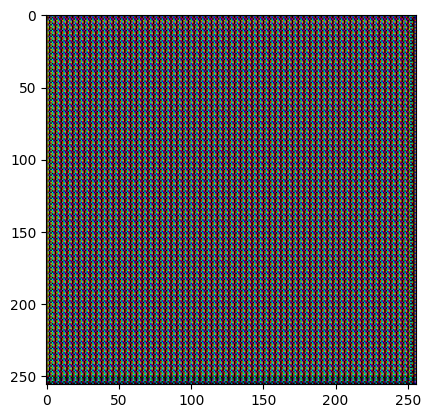

In [16]:

plt.imshow(final_image)
plt.show()